In [29]:
import argparse
import logging
import os
from os.path import splitext
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import segmentation_models_pytorch as smp
from unet import SiamUNetConCResnet50,vgg19nobn_unetdouble,VGG16Unet,resnet_unet,resnet_siamunet,SiamUNetDiffVgg19Space, SiamUNetFullConCVgg19,SiamUNetDiffVgg19,UNETResnet50,UNet,SiamUNet,SiamUNetConC,SiamUNetDiff, SiamUNetConCVgg19, VGG19Unet,vgg19bn_unet,vgg19nobn_unet,vgg16bn_unet, UNetWithResnet50Encoder, UNetWithVgg19BnEncoder, SiameseUNetWithResnet50Encoder, SiamUnet_diff_Full, SiameseUNetV2
from unet import UNet
from utils.utils import plot_img_and_mask
import torchvision.transforms as T

In [50]:
def load(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)

def predict_img(net,
                full_img,
                pre_full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    transform = T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    net.eval()
    img = torch.from_numpy(np.asarray(full_img)/255)
    preimg = torch.from_numpy(np.asarray(pre_full_img)/255)

    img = img.unsqueeze(0)
    img = transform(torch.as_tensor(img.permute(0, 3, 1, 2)).float().contiguous())
    img = img.to(device=device, dtype=torch.float32)
    preimg = preimg.unsqueeze(0)
    preimg = transform(torch.as_tensor(preimg.permute(0, 3, 1, 2)).float().contiguous())
    preimg = preimg.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(preimg,img)

        if 5 > 1:
            probs = F.softmax(output, dim=1)[0]
        else:
            probs = torch.sigmoid(output)[0]

        full_mask = probs.cpu()
    if 5 == 1:
        return (full_mask > out_threshold).numpy()
    else:
        return F.one_hot(full_mask.argmax(dim=0), 5).permute(2, 0, 1).numpy()

def get_output_filenames(args):
    def _generate_name(fn):
        return f'{os.path.splitext(fn)[0]}_OUT.png'

    return args.output or list(map(_generate_name, args.input))


def mask_to_image(mask: np.ndarray):
    if mask.ndim == 2:
        return Image.fromarray((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return Image.fromarray((np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8))

None
C:\Users\thanh/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
loading model
model loaded


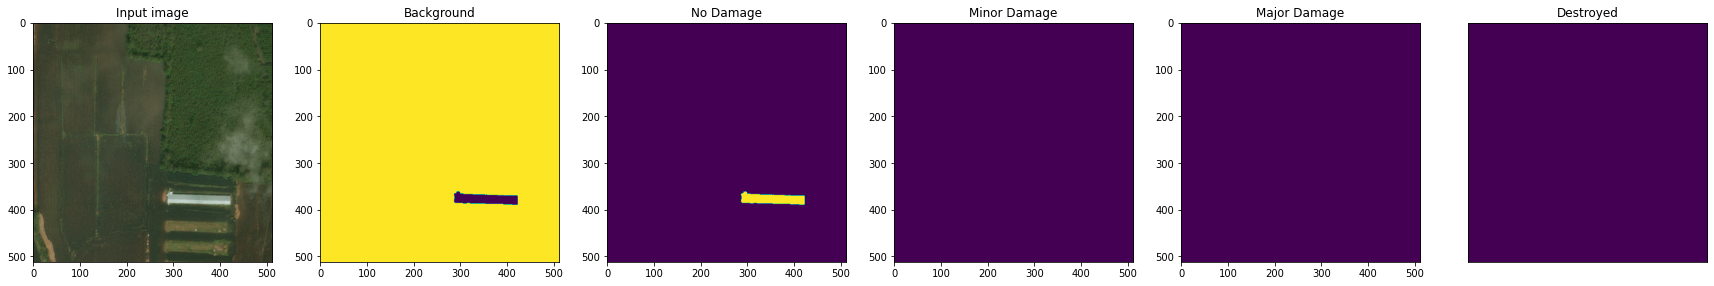

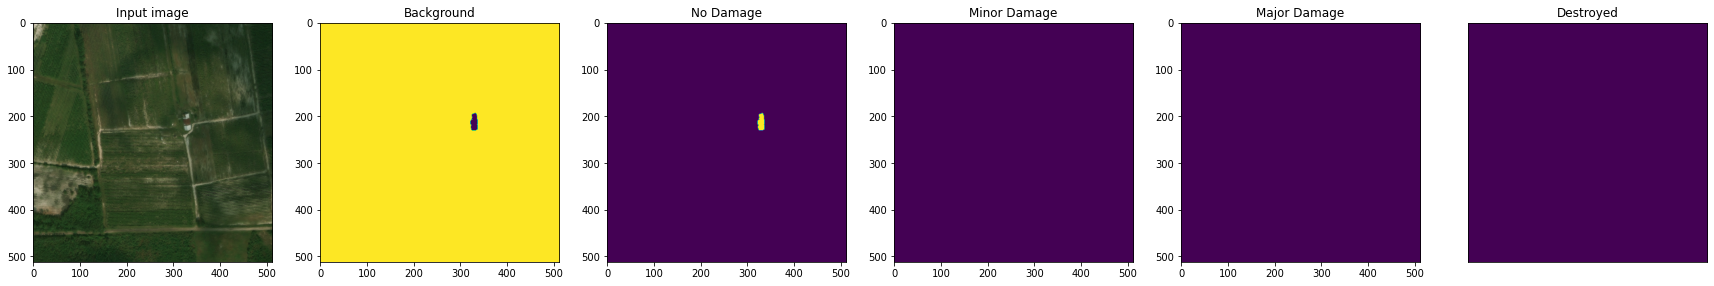

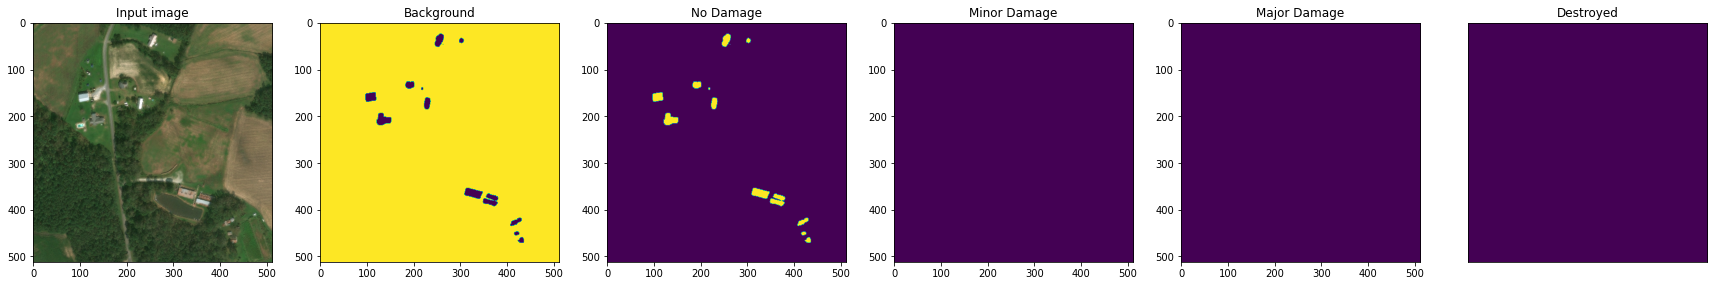

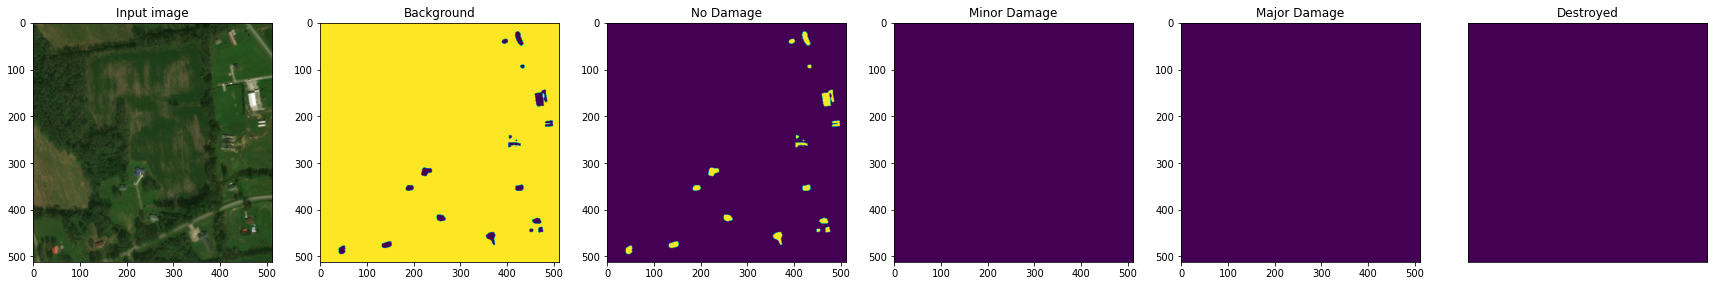

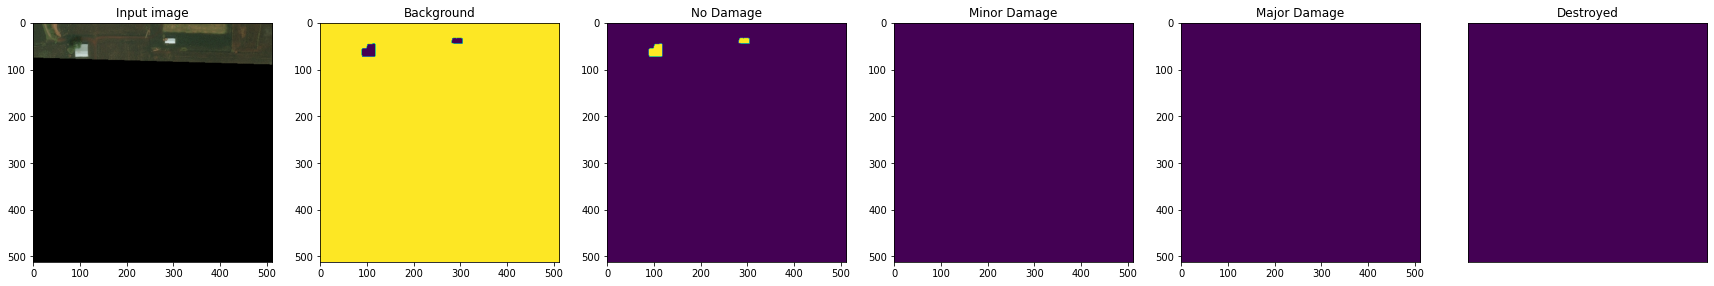

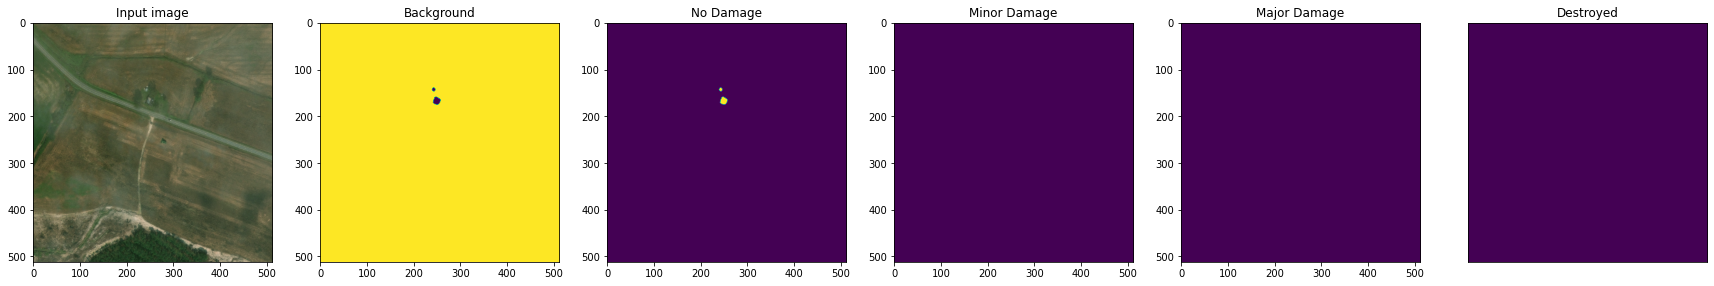

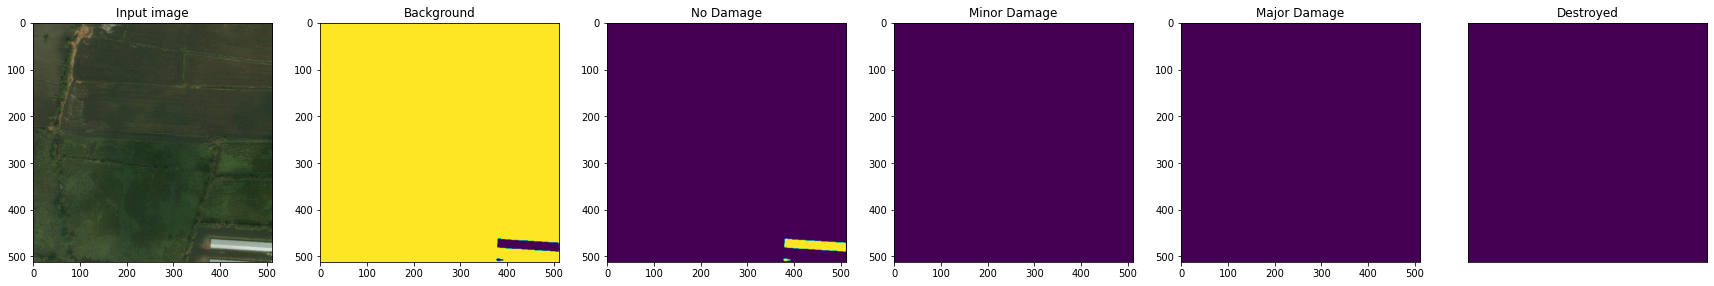

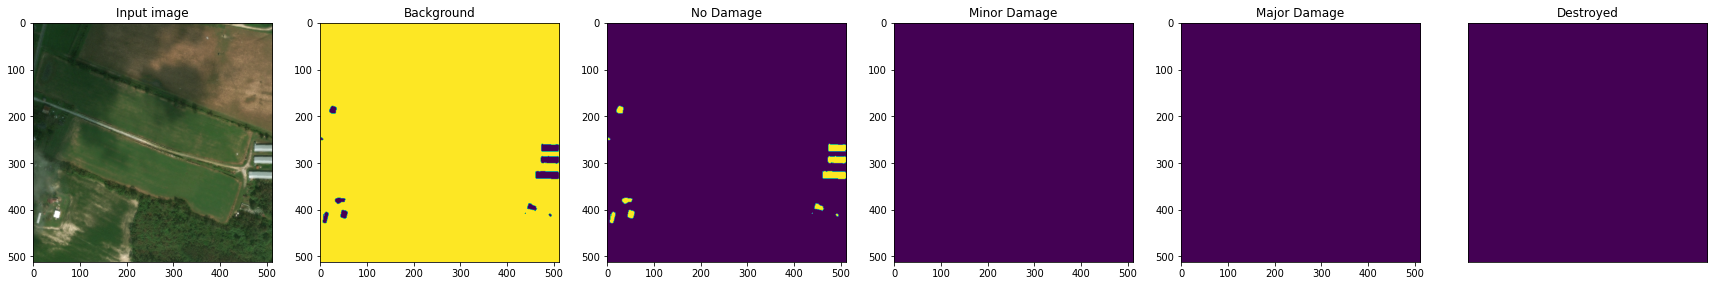

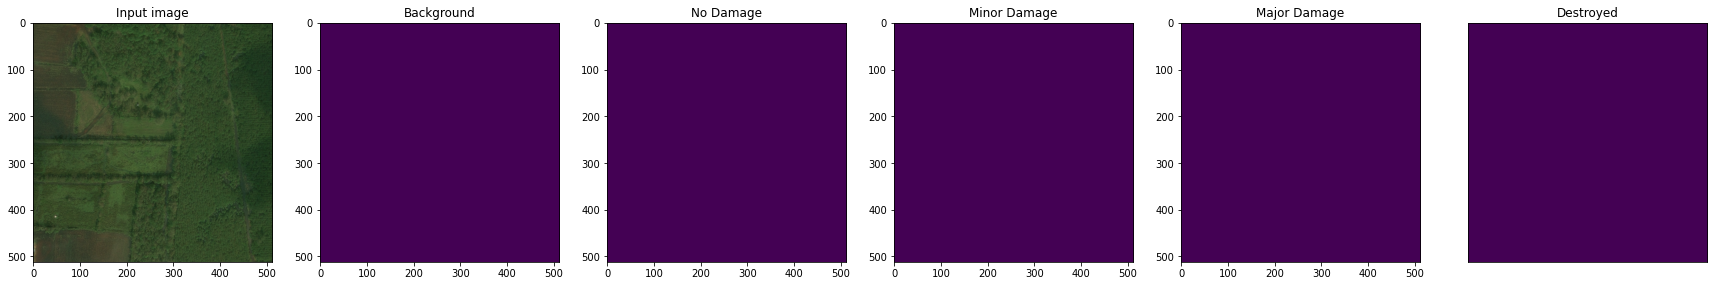

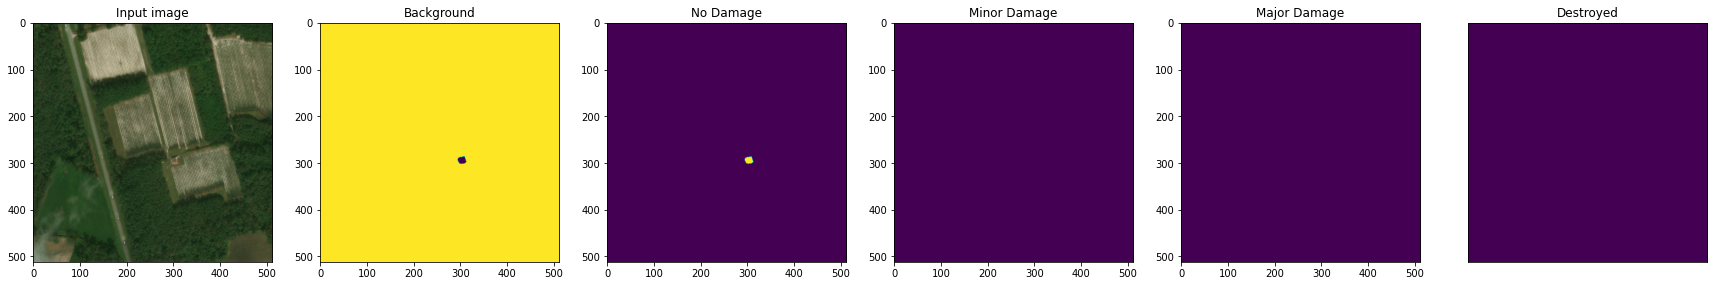

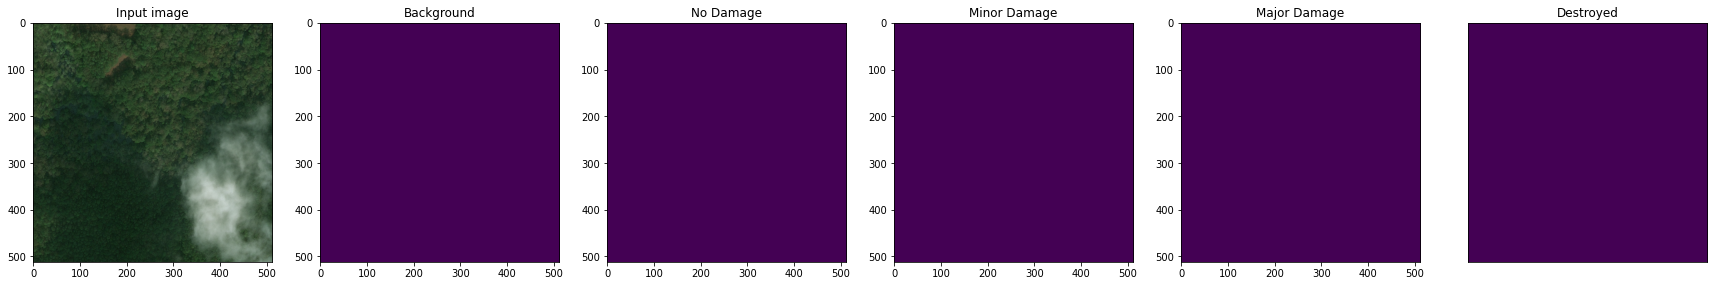

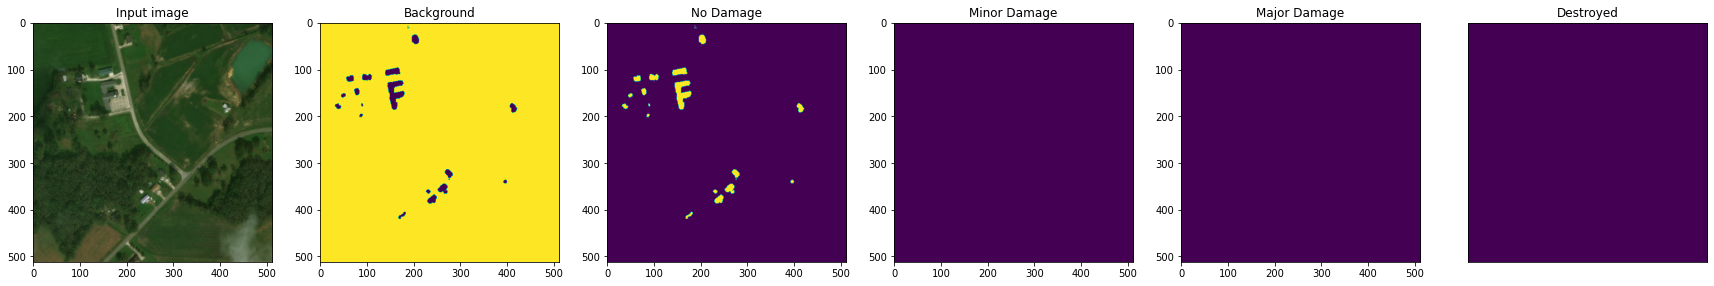

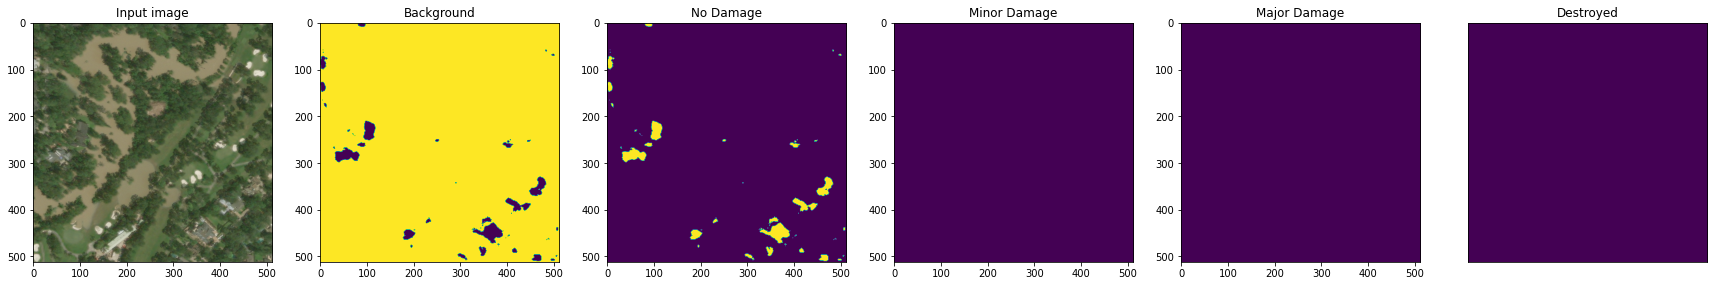

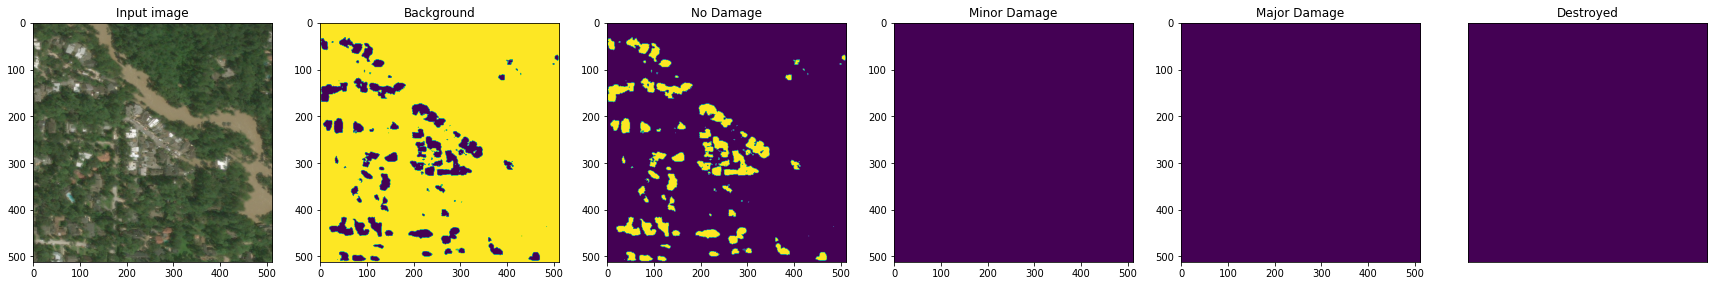

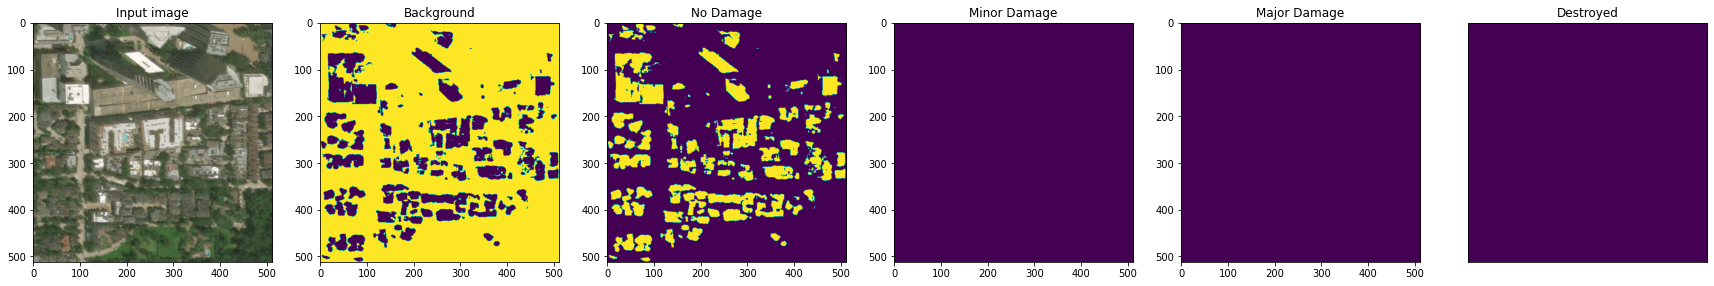

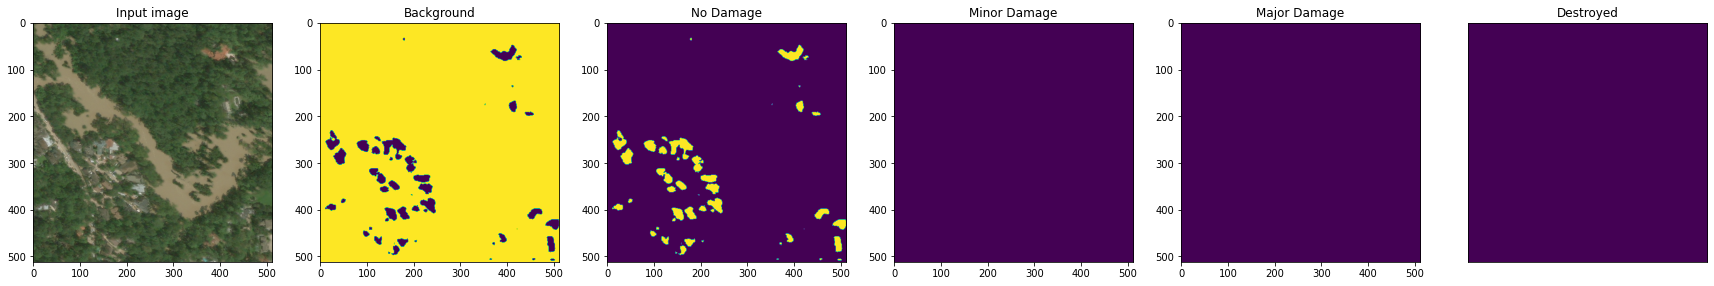

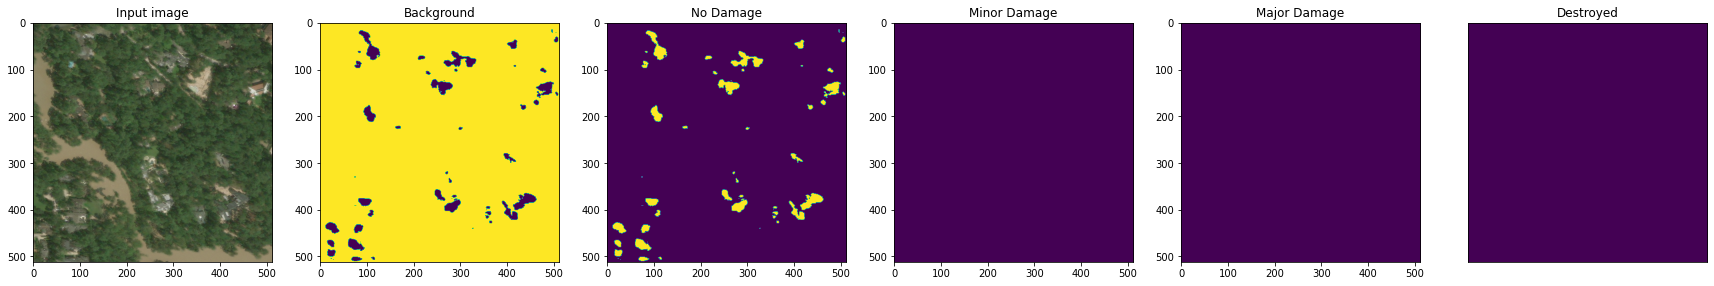

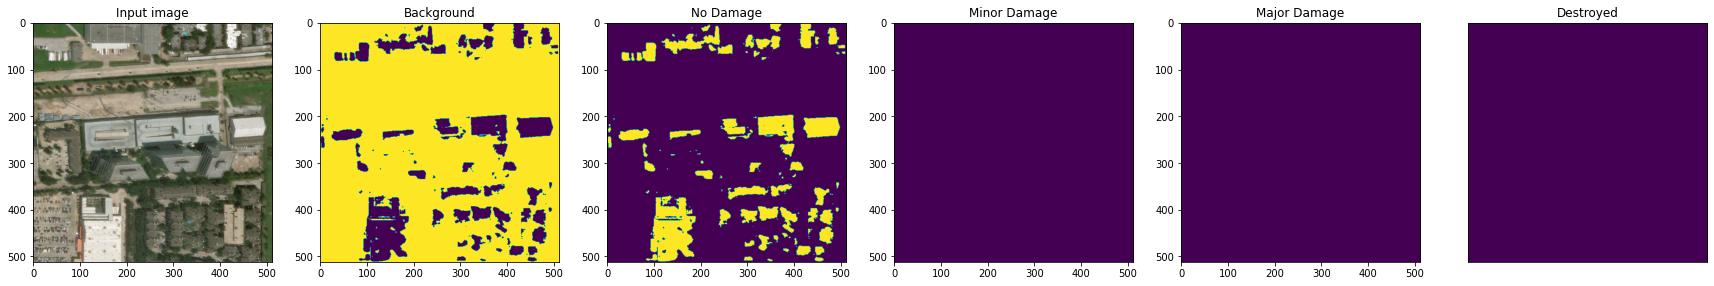

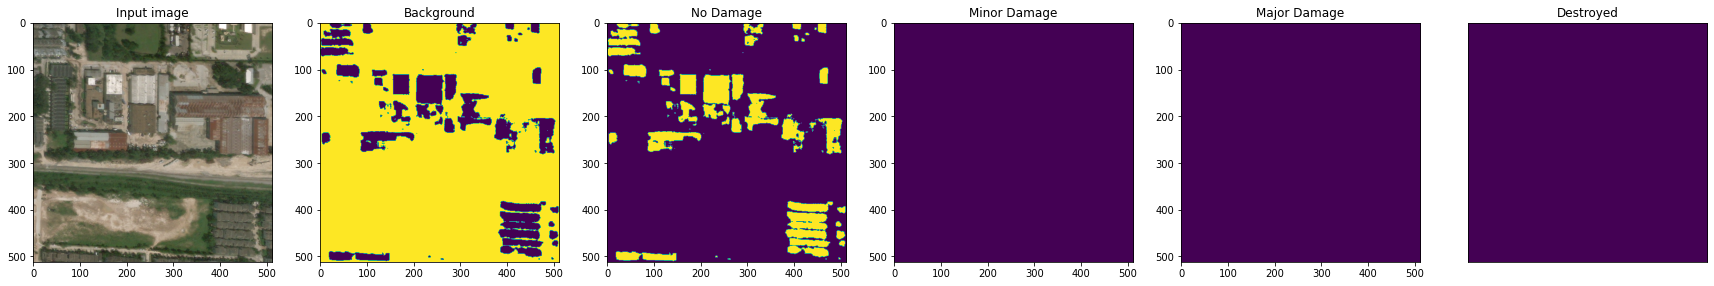

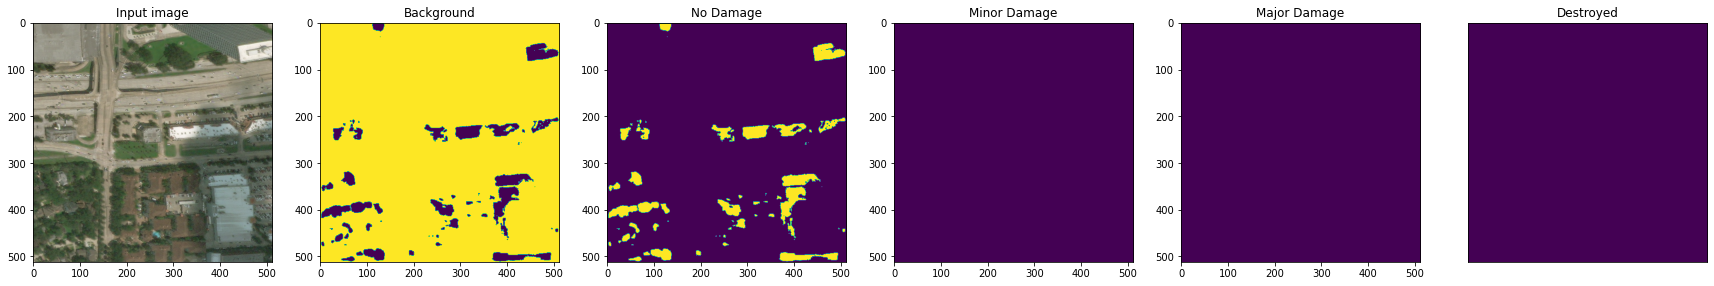

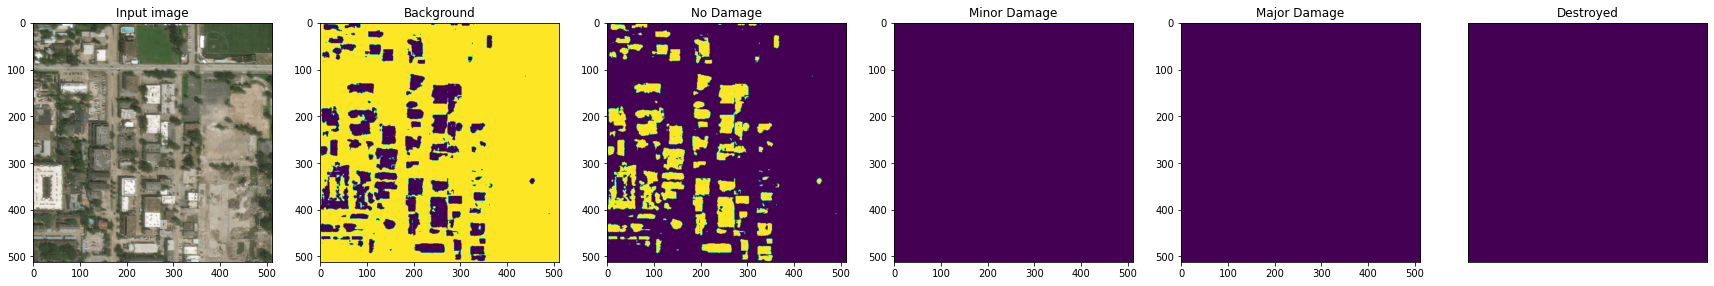

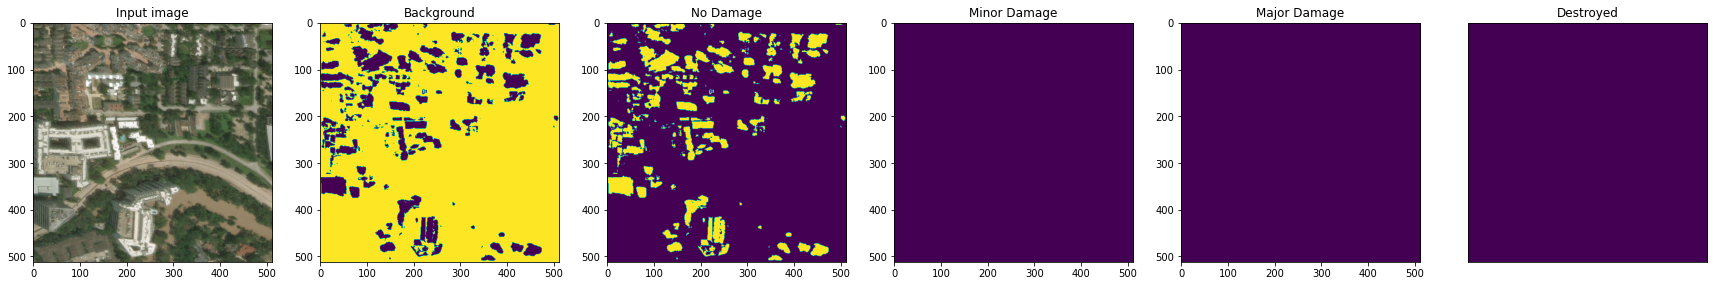

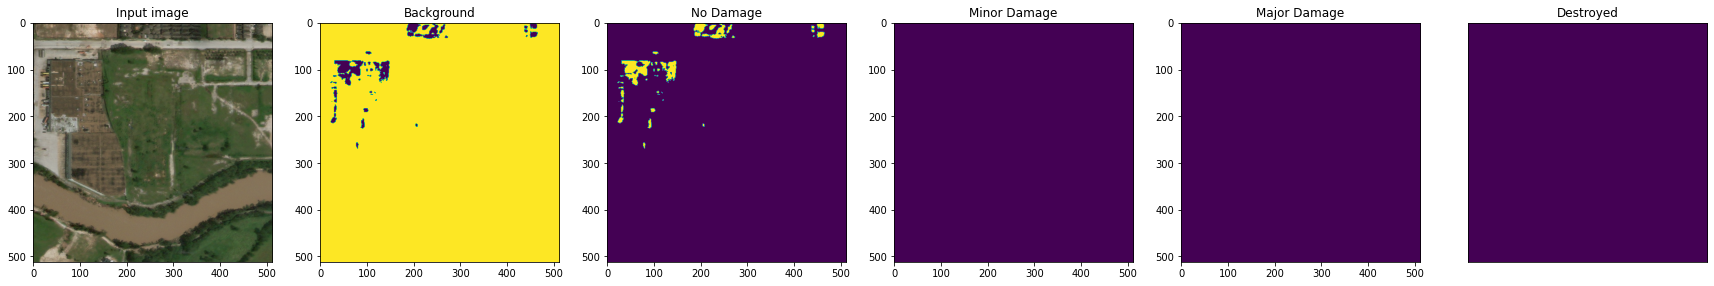

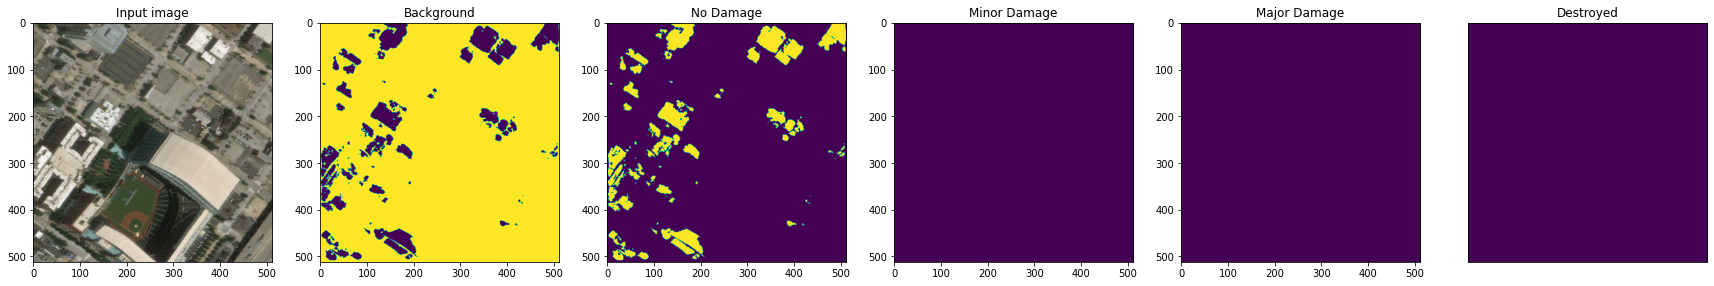

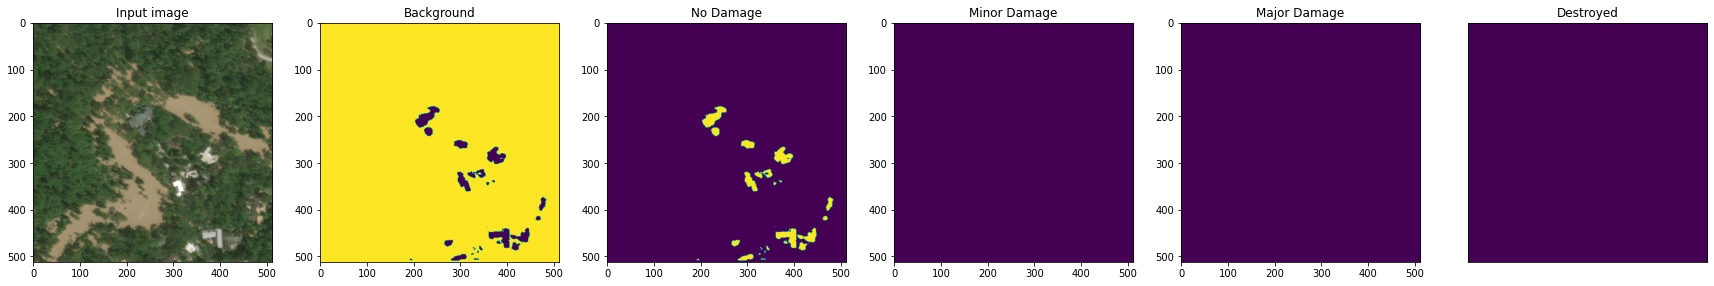

In [51]:
checkpoint = '.\\checkpoints\\Final\\branch12checkpoint_epoch_branch_21.pth'
dir_img = '.\\Dataset\\Tier1\\Post\\Image512\\'
dir_mask = '.\\Dataset\\Tier1\\Post\\Label512\\'
pre_dir_img = '.\\Dataset\\Tier1\\Post\\Image512\\'
mask_threshold = 0.5
no_save = True
viz = True
scale = 1
labels = ['Background','No Damage','Minor Damage','Major Damage','Destroyed']
A = 325
B = 350
if __name__ == '__main__':
    in_files = [dir_img + s for s in os.listdir(dir_img)][A:B]
    pre_in_files = [pre_dir_img + s for s in os.listdir(pre_dir_img)][A:B]
    out_files = [dir_mask + s for s in os.listdir(dir_mask)][A:B]

    net = SiamUNetConCVgg19()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('loading model')

    net.to(device=device)
    net.load_state_dict(torch.load(checkpoint, map_location=device))

    print('model loaded')
    for i, files in enumerate(zip(pre_in_files,in_files)):
        img = load(files[1])
        preimg = load(files[0])
        mask = predict_img(net=net,
                           full_img=img,
                           pre_full_img =preimg,
                           scale_factor=scale,
                           out_threshold=mask_threshold,
                           device=device)

        if not no_save:
            out_filename = out_files[i]
            result = mask_to_image(mask)
            result.save(out_filename)

        if viz:
            plot_img_and_mask(img, mask,labels)